# Import Libraries

In [0]:
import numpy as np
import pandas as pd
import os
import glob
import cv2
import shutil
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.models import model_from_json
from matplotlib import pyplot as plt
from keras import backend as K
from keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from keras import utils
import dlib
from PIL import Image

### Getting Images and labels with bbox from CelebA Daraset

In [0]:
lab = pd.read_csv('identity_CelebA.txt',sep=" ",names = ['image_id','labels'])
bbox = pd.read_csv('list_bbox_celeba.txt')
bbox = bbox['202599'].str.split(expand = True,)
bbox = bbox.rename(columns = bbox.iloc[0])
bbox = bbox.drop(bbox.index[0]).reset_index(drop = True)
final = pd.merge(lab, bbox, on = 'image_id', how = 'inner')

In [59]:
final.head()

,image_id,labels,x_1,y_1,width,height
0,000001.jpg,2880,95,71,226,313
1,000002.jpg,2937,72,94,221,306
2,000003.jpg,8692,216,59,91,126
3,000004.jpg,5805,622,257,564,781
4,000005.jpg,9295,236,109,120,166


### Plot of sample Images

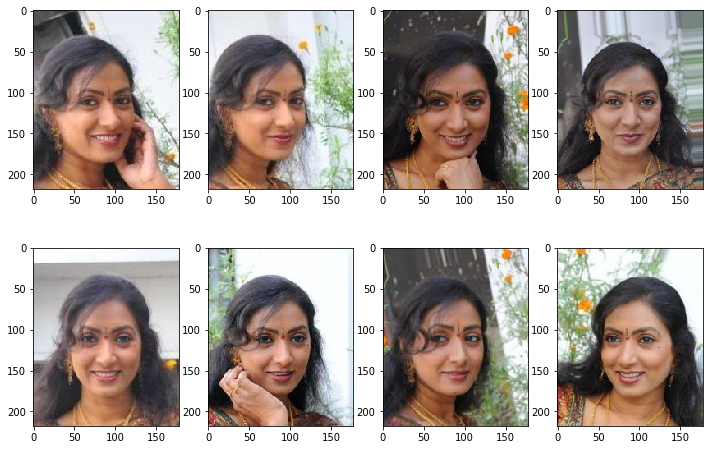

In [61]:
files = final.iloc[final['labels'].values == 11]['image_id'].values
rnd_files = np.random.choice(files, 8, replace=False)
PATH = './data/celebA/'
plt.figure(figsize=(12,8))
for i, file in enumerate(rnd_files):
    plt.subplot(2,4,i+1)
    img = plt.imread(PATH + '{}'.format(file))
    plt.imshow(img)

In [0]:
face_detector_dlib = dlib.get_frontal_face_detector()

In [0]:
final = pd.merge(lab, bbox, on='image_id', how='inner')
final = final[final['labels'].isin(list(final.labels.value_counts()[:23].index))].reset_index(drop=True)
final['labels'] = final.labels.apply(lambda x: str(x))
new_d = {}
j =0
for i in list(final.labels.unique()):
  new_d[i]=j
  j=j+1
final['labels'] = final['labels'].apply(lambda x : new_d[x])

def loadImages_with_dlib():
    file_name =[]
    imgs_array = []
    error_file_name = []
    labels = []
    for img_file in list(final.image_id):
        try:
            im = cv2.imread('./data/celebA/{}'.format(img_file), 0)
            detected_faces = face_detector_dlib(im, 1)
            for j, face_rect in enumerate(detected_faces):
                label=int(final[final['image_id']==img_file.split('/')[-1]].to_dict(orient='record')[0]['labels'])   
                crop = im[face_rect.top():face_rect.bottom(), face_rect.left():face_rect.right()]
                face = cv2.resize(crop,(100,100))
                file_name.append(img_file)
                imgs_array.append(face)
                labels.append(label)
                break
        except:
            print(img_file)
    return imgs_array, file_name, labels

In [75]:
data, filenames, labels = loadImages_with_dlib()

080638.jpg


In [0]:
one_hot_labels = utils.to_categorical(labels, 23)

In [0]:
data = np.array(data)
data = data.reshape(-1,100,100,1)
data = data/255.0
data = data - data.mean()

In [79]:
data.shape,one_hot_labels.shape

((706, 100, 100, 1), (706, 23))

In [0]:
X_train,X_test,y_train,y_test = train_test_split(data,one_hot_labels,test_size=0.2)

In [81]:
X_train.shape,y_train.shape,X_test.shape

((564, 100, 100, 1), (564, 23), (142, 100, 100, 1))

In [0]:
def createmodel():
    model = Sequential()
    model.add(Convolution2D(32, (5, 5) , init='he_normal',activation='relu',input_shape=(100,100,1)))
    model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="tf"))

    model.add(Convolution2D(64,( 5, 5),activation='relu', init='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="tf"))

    model.add(Convolution2D(128, (5, 5),activation='relu', init='he_normal'))
    model.add(MaxPooling2D(pool_size=(2,2),dim_ordering="tf"))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(100,activation='relu'))
    
    model.add(Dense(23,activation='softmax'))

    model.compile(Adam(lr=1e-3), loss='categorical_crossentropy',metrics=['accuracy'])
    print(model.summary())
    return model


In [96]:
from keras.callbacks import ModelCheckpoint

model = createmodel()
checkpoint = ModelCheckpoint('dlib_celebA.h5', monitor='val_loss', 
                             verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit(X_train, y_train, batch_size=4, epochs=100,
               verbose=1, validation_data = (X_test, y_test), callbacks=[checkpoint])
# Load best model
model.load_weights('dlib_celebA.h5')

# And save the whole model
model.save('dlib_celebA.h5', include_optimizer=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", input_shape=(100, 100,..., kernel_initializer="he_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_last")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation="relu", kernel_initializer="he_normal")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_last")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9:

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 96, 96, 32)        832       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 44, 44, 64)        51264     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 18, 18, 128)       204928    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 9, 9, 128)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 9, 9, 128)        


### General Utility for getting output of any layer of the model


In [0]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function

In [0]:
# testing a image, second img here
x = functor([[data[2]],0]) #learning phase: 1(train)

In [99]:
len(x)

10

In [100]:
for i in range(10):
    print(x[i].shape)

(1, 96, 96, 32)
(1, 48, 48, 32)
(1, 44, 44, 64)
(1, 22, 22, 64)
(1, 18, 18, 128)
(1, 9, 9, 128)
(1, 9, 9, 128)
(1, 10368)
(1, 100)
(1, 23)


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


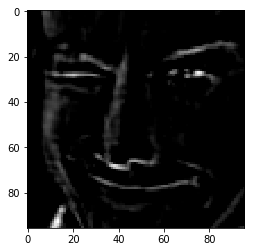

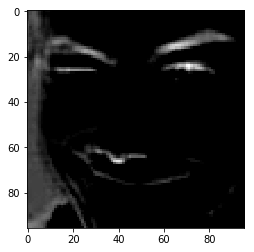

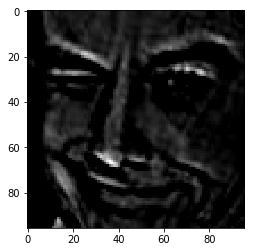

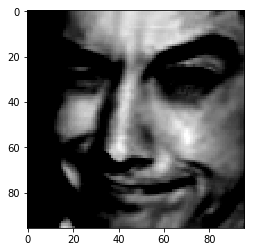

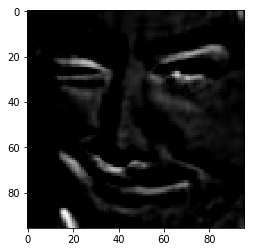

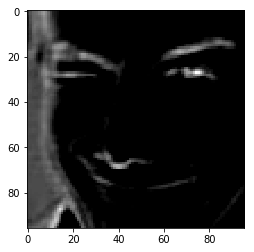

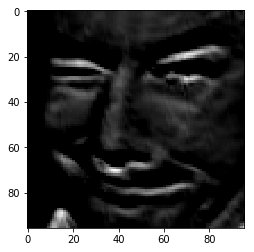

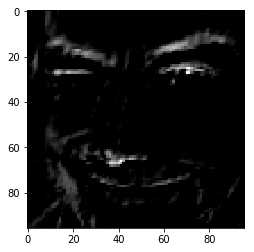

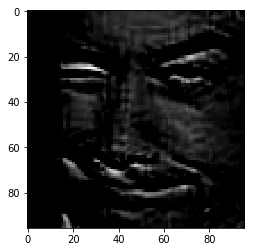

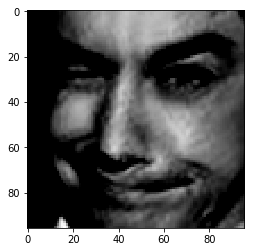

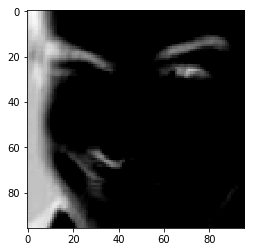

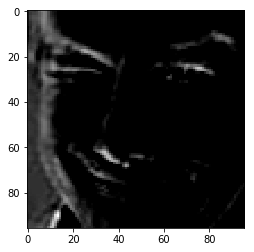

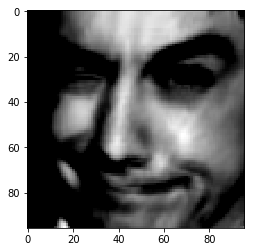

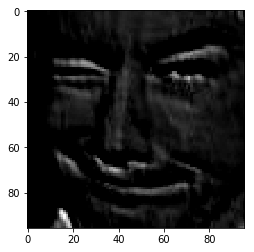

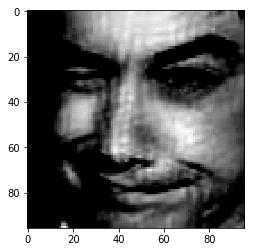

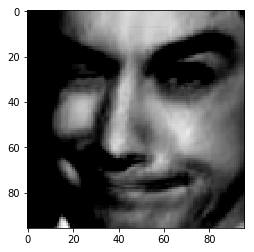

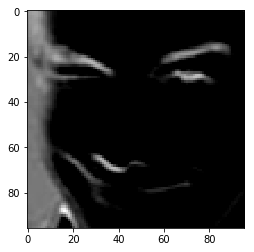

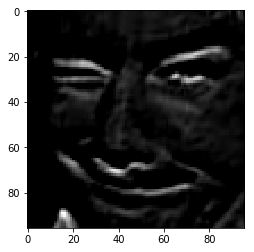

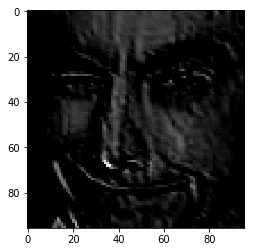

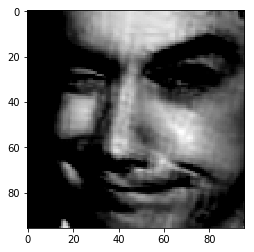

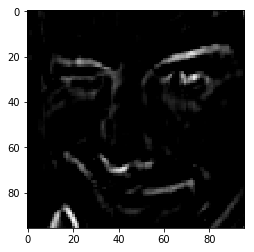

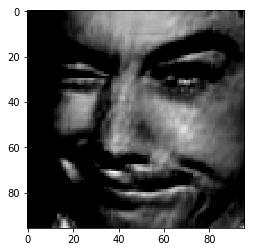

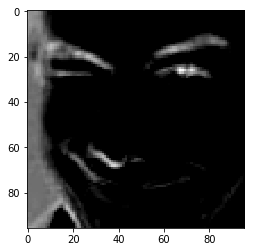

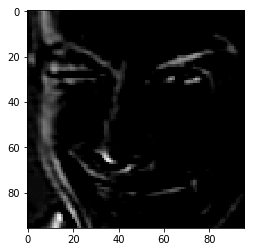

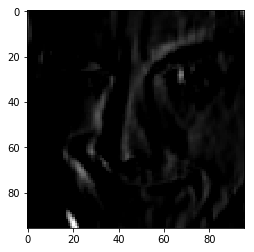

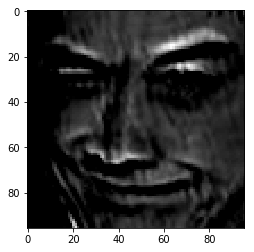

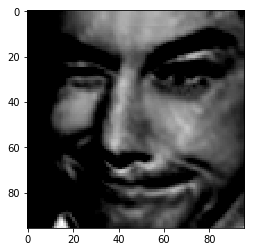

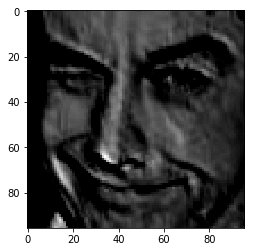

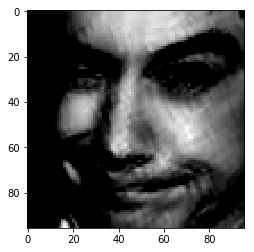

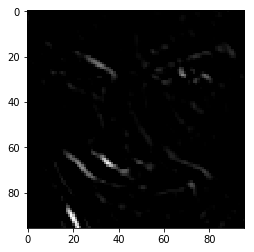

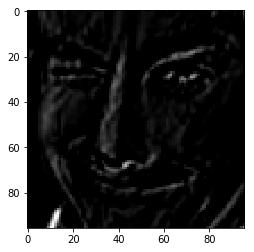

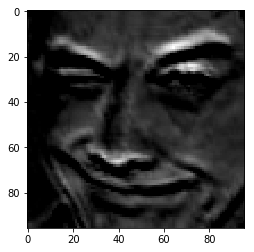

In [101]:
for i in range(32):
    plt.figure()
    plt.imshow(x[0][0,:,:,i],cmap='gray')



# Testing the model


In [0]:
import numpy as np
import os
import glob
import cv2
import shutil
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.models import model_from_json
from matplotlib import pyplot as plt
from keras import backend as K
from keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from keras import utils
from PIL import Image
import dlib
%matplotlib inline

In [103]:

model.load_weights("dlib_celebA.h5")
print("Loaded model from disk")

Loaded model from disk


In [0]:


inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function



In [0]:
face_detector_dlib = dlib.get_frontal_face_detector()

In [0]:
def show(im):
    plt.figure()
    plt.imshow(im[:,:,0],cmap='gray')

In [0]:
def load_img(img):
    im = cv2.imread('./data/celebA/{}'.format(img),0)
    detected_faces = face_detector_dlib(im, 1)
    for j, face_rect in enumerate(detected_faces):
        crop = im[face_rect.top():face_rect.bottom(), face_rect.left():face_rect.right()]
        face = cv2.resize(crop,(100,100))
    return face.reshape(100,100,1)

In [0]:
def similarity(im1,im2):
    show(im1)
    show(im2)
    f1 = functor([[im1],0])[7][0] #flatten layer output
    f2 = functor([[im2],0])[7][0]
    return cosine_similarity([f1],[f2])

In [0]:


def compare(im1_path, im2_path):
    im1 = load_img(im1_path)
    im2 =load_img(im2_path)
    return similarity(im1,im2)



array([[0.29700392]], dtype=float32)

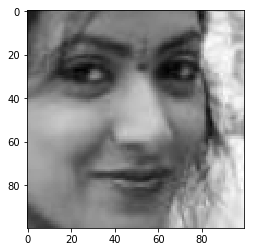

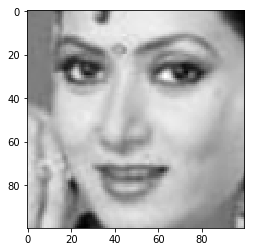

In [110]:
compare(files[1],files[3])